<a href="https://colab.research.google.com/github/shyammarjit/BCI-for-affective-computing/blob/main/STEP%3A2%20Channel%20Selection%20BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold 
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")
!pip install skfeature-chappers
drive._mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

# Fisher Score

In [ ]:
import numpy as np
from skfeature.utility.construct_W import construct_W
from scipy.sparse import diags
def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature
    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """
    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)

In [ ]:
def feature_wise_mean(X, i):
  # ith feature
  mysum  = 0
  for k in range(0, X.shape[0]):
    mysum = mysum + X[k][i]
  return mysum/X.shape[0]
def compute_sigma_and_uij(X, y, i, j):
  draft = []
  for s in range(0, X.shape[0]):
    if(y[s]==j):
      draft.append(X[s][i])
  draft = np.array(draft)
  return np.mean(draft), np.var(draft)
def fisher_score_without_laplace(X, y):
  f_score = np.ones(X.shape[1])
  # how many class
  classes = list(set(y))
  nj = np.ones(len(classes))
  # compute no of samples in each class
  for s in range(0, len(classes)):
    count_class = 0
    for k in range(0, X.shape[0]):
      if(y[k]==classes[s]):
        count_class = count_class + 1
    nj[s] = count_class
  for i in range(0, X.shape[1]):
    # for each feature compute the f score 
    ui = feature_wise_mean(X, i)
    upper, lower = 0, 0
    for j in classes:
      uij, sigma_ij = compute_sigma_and_uij(X, y, i, j)
      upper = upper + nj[j]*((uij-ui)**2)
      lower = lower + nj[j]*(sigma_ij**2)
    f_score[i] = upper/lower
  return f_score

In [ ]:
def emotion_label(labels, class_label):
	em_labels = []
	if(class_label == "valence"):
		for i in range(0, labels.shape[0]):
			if (labels[i][0]>5): # high valence
				em_labels.append(1)
			else: # low valence
				em_labels.append(0)
		return em_labels
	elif(class_label == "arousal"):
		for i in range(0, labels.shape[0]):
			if (labels[i][1]>5): # high arousal
				em_labels.append(1)
			else: # low arousal
				em_labels.append(0)
		return em_labels
	elif(class_label == "all"):
		for i in range(0, labels.shape[0]):
			if (labels[i][0]>5): # high valence
				if(labels[i][1]>5): # high arousal
					em_labels.append(1) # HVHA
				else:
					em_labels.append(0) # HVLA
			else: # low valence
				if(labels[i][1]>5): # high arousal
					em_labels.append(2) # LVHA
				else: # low arousal
					em_labels.append(3) # LVLA
		return em_labels

In [ ]:
def get_fisher_score(subject_name, em_labels):
  mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
  # for theta band
  data_theta = pd.read_csv(mypath + '_theta.csv')
  X, y = np.array(data_theta), np.array(em_labels)
  f_score_theta = fisher_score(X, y)
  #print(f_score_theta)
  # for alpha band
  data_alpha = pd.read_csv(mypath + '_alpha.csv')
  X, y = np.array(data_alpha), np.array(em_labels)
  f_score_alpha = fisher_score(X, y)
  #print(f_score_alpha)
  # for beta band
  data_beta = pd.read_csv(mypath + '_beta.csv')
  X, y = np.array(data_beta), np.array(em_labels)
  f_score_beta = fisher_score(X, y)
  # for gamma band
  data_gamma = pd.read_csv(mypath + '_gamma.csv')
  X, y = np.array(data_gamma), np.array(em_labels)
  f_score_gamma = fisher_score(X, y)
  # Total Avearge F-Score (Theta, Alpha, Beta, Gamma)
  final_f_score = (f_score_theta + f_score_alpha + f_score_beta + f_score_gamma)/4
  eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
  fvalues = pd.Series(final_f_score)
  fvalues.index = eeg_channels
  fvalues.sort_values(ascending=False)
  fvalues.to_csv('fscore_final.csv')
  #fvalues.sort_values(ascending = False).plot.bar(figsize=(10,8))
  shyam = fvalues.sort_values(ascending = False)
  da = pd.DataFrame(shyam)
  da.to_csv("channel_rank.csv")
  cr = pd.read_csv("channel_rank.csv")
  sort_channel_name = list(cr["Unnamed: 0"])
  return sort_channel_name

# Classification

In [ ]:
#Loading the dataset
def svmclassifier(channel_name, status = False):
  channel_names = []
  mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
  data = pd.read_csv(mypath + '.csv')
  for i in range(0, len(channel_name)):
    draft = channel_name[i]
    channel_names.append(draft + "_alpha")
    channel_names.append(draft + "_beta")
    channel_names.append(draft + "_gamma")
    channel_names.append(draft + "_theta")
  x = data[channel_names]
  y = np.array(em_labels)
  # Implementing cross validation
  k = 40
  kf = KFold(n_splits = k, shuffle = status)
  acc_score = []
  for train_index , test_index in kf.split(x):
      x_train , x_test = x.iloc[train_index,:],x.iloc[test_index,:]
      y_train , y_test = y[train_index] , y[test_index]
      model = svm.SVC(kernel='poly')
      model.fit(x_train, y_train)
      pred_values = model.predict(x_test)
      #pred_values = model.predict(x_test)
      acc = accuracy_score(pred_values , y_test)
      acc_score.append(acc)
  avg_acc_score = sum(acc_score)/k
  return avg_acc_score

In [ ]:
def growing_phase(channel_name):
  mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
  data = pd.read_csv(mypath + '.csv')
  cn = channel_name[0]
  acc = svmclassifier([cn])
  cn_list = []
  cn_list.append(cn)
  sort_cn = []
  for i in range(1, len(channel_name)):
    cur_cn = channel_name[i]
    cn_list.append(cur_cn)
    cur_acc = svmclassifier(cn_list)
    if(cur_acc<acc):
      # remove the curent channel name
      #print("Removing channel name: ", cur_cn)
      cn_list.remove(cur_cn)
    else:
      acc = cur_acc
  print("Accuracy in Growing Phase: ", acc)
  print("No of selected channels in Growing Phase: ", len(cn_list))
  print("Channels selected in Growing Phase: ", cn_list)
  return cn_list

In [ ]:
def pruning_phase_get_fscore(optimal_channel_name, subject_name, em_labels):
  ocn = []
  mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
  # for theta band
  data_theta = pd.read_csv(mypath + '_theta.csv')
  # select those particular channels theta band value only
  for i in range(0, len(optimal_channel_name)):
    ocn.append(optimal_channel_name[i] + "_theta")
  draft_theta = data_theta[ocn]
  X, y = np.array(draft_theta), np.array(em_labels)
  f_score_theta = fisher_score(X, y)
  # for alpha band
  data_alpha = pd.read_csv(mypath + '_alpha.csv')
  ocn = []
  # select those particular channels alpha band value only
  for i in range(0, len(optimal_channel_name)):
    ocn.append(optimal_channel_name[i] + "_alpha")
  draft_alpha = data_alpha[ocn]
  X, y = np.array(draft_alpha), np.array(em_labels)
  f_score_alpha = fisher_score(X, y)
  # for beta band
  data_beta = pd.read_csv(mypath + '_beta.csv')
  ocn = []
  # select those particular channels beta band value only
  for i in range(0, len(optimal_channel_name)):
    ocn.append(optimal_channel_name[i] + "_beta")
  draft_beta = data_beta[ocn]
  X, y = np.array(draft_beta), np.array(em_labels)
  f_score_beta = fisher_score(X, y)
  # for gamma band
  data_gamma = pd.read_csv(mypath + '_gamma.csv')
  ocn = []
  # select those particular channels alpha band value only
  for i in range(0, len(optimal_channel_name)):
    ocn.append(optimal_channel_name[i] + "_gamma")
  draft_gamma = data_gamma[ocn]
  X, y = np.array(draft_gamma), np.array(em_labels)
  f_score_gamma = fisher_score(X, y)
  # Total Avearge F-Score (Theta, Alpha, Beta, Gamma)
  final_f_score = (f_score_theta + f_score_alpha + f_score_beta + f_score_gamma)/4
  fvalues = pd.Series(final_f_score)
  fvalues.index = optimal_channel_name
  fvalues.sort_values(ascending=False)
  fvalues.to_csv('fscore_final.csv')
  #fvalues.sort_values(ascending = False).plot.bar(figsize=(10,8))
  shyam = fvalues.sort_values(ascending = False)
  da = pd.DataFrame(shyam)
  da.to_csv("channel_rank.csv")
  cr = pd.read_csv("channel_rank.csv")
  sort_channel_name = list(cr["Unnamed: 0"])
  return sort_channel_name

In [ ]:
def pruning_phase(sort_channel_name):
  # check the accuracy for taking all the channels
  acc = svmclassifier(sort_channel_name)
  if(len(sort_channel_name)==1):
    print("Accuracy in Pruning Phase: ", acc)
    print("No of selected channels in Pruning Phase: ", len(sort_channel_name))
    print("Channels selected in Pruning Phase: ", sort_channel_name)
    return sort_channel_name
  for i in range(0, len(sort_channel_name)):
    cur_cn = sort_channel_name[0:(len(sort_channel_name)-i-1)] # remove for the last channel
    cur_acc = svmclassifier(cur_cn)
    if(cur_acc>acc): # accuracy improved then remove that channel
      acc = cur_acc
      continue
    else: # take that channel
      cur_cn = sort_channel_name[0:(len(sort_channel_name)-i)]
      break
  print("Accuracy in Pruning Phase: ", acc)
  print("No of selected channels in Pruning Phase: ", len(cur_cn))
  print("Channels selected in Pruning Phase: ", cur_cn)
  return cur_cn

# Test drive Code

In [ ]:
#subject_name = input("Enter the subject name: (for example: 's01'): \n")
#class_label = input("Enter the label ('valence', 'arousal', 'all'): \n")
subject_name = "s01"
class_label = "valence"
link = "/content/drive/MyDrive/Deap/" + subject_name + ".dat"
with open(link, 'rb') as f:
  raw_data = pickle.load(f, encoding = 'latin1')
labels = raw_data['labels']
em_labels = emotion_label(labels, class_label) # get the emotion labels
channel_name = get_fisher_score(subject_name, em_labels)
optimal_channel_name = growing_phase(channel_name)
sort_channel_name = pruning_phase_get_fscore(optimal_channel_name, subject_name, em_labels)
final_channel_name = pruning_phase(sort_channel_name)

Accuracy in Growing Phase:  0.725
No of selected channels in Growing Phase:  6
Channels selected in Growing Phase:  ['Fz', 'FC2', 'CP6', 'F7', 'Fp1', 'FC6']
Accuracy in Pruning Phase:  0.725
No of selected channels in Pruning Phase:  6
Channels selected in Pruning Phase:  ['Fz', 'FC2', 'CP6', 'F7', 'Fp1', 'FC6']


In [ ]:
print(channel_name)

['Fz', 'FC2', 'CP6', 'Pz', 'P8', 'F4', 'CP1', 'AF4', 'CP2', 'P7', 'CP5', 'Fp2', 'AF3', 'F7', 'Fp1', 'Oz', 'F3', 'C4', 'PO3', 'FC1', 'O2', 'C3', 'O1', 'FC5', 'PO4', 'T8', 'F8', 'Cz', 'P3', 'FC6', 'T7', 'P4']


In [ ]:
print(svmclassifier(['CP1', 'P3', 'P8', 'Fz'])) # s01 arousal
print(svmclassifier(['FC2', 'CP6', 'F7'])) # s01 valence

0.6
0.775


In [ ]:
svmclassifier(['Fz', 'FC2', 'CP6', 'F7', 'Fp1', 'FC6'])

0.725

In [ ]:
channel_name = ['Fz', 'FC2', 'CP6', 'F7', 'Fp1', 'FC6']
channel_names = []
mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
data = pd.read_csv(mypath + '.csv')
for i in range(0, len(channel_name)):
  draft = channel_name[i]
  channel_names.append(draft + "_alpha")
  channel_names.append(draft + "_beta")
  channel_names.append(draft + "_gamma")
  channel_names.append(draft + "_theta")
x = data[channel_names]

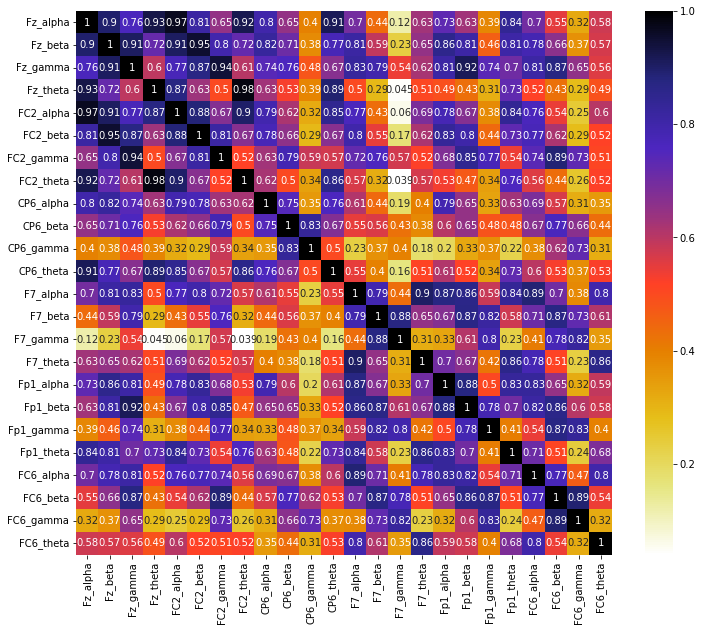

In [ ]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = x.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(x, 0.90)
len(set(corr_features))

9

In [ ]:
x = x.drop(corr_features,axis=1)

In [ ]:
svmclassifier_draft(status = False)

0.3

In [ ]:
#Loading the dataset
def svmclassifier_draft(status = False):
  y = np.array(em_labels)
  # Implementing cross validation
  k = 40
  kf = KFold(n_splits = k, shuffle = status)
  acc_score = []
  for train_index , test_index in kf.split(x):
      x_train , x_test = x.iloc[train_index,:],x.iloc[test_index,:]
      y_train , y_test = y[train_index] , y[test_index]
      model = svm.SVC(kernel='poly')
      model.fit(x_train, y_train)
      pred_values = model.predict(x_test)
      #pred_values = model.predict(x_test)
      acc = accuracy_score(pred_values , y_test)
      acc_score.append(acc)
  avg_acc_score = sum(acc_score)/k
  return avg_acc_score

In [ ]:
svmclassifier(['CP1', 'P3', 'P8', 'Fz'])

0.6

In [ ]:
#subject_name = input("Enter the subject name: (for example: 's01'): \n")
#class_label = input("Enter the label ('valence', 'arousal', 'all'): \n")
subject_name = "s01"
class_label = "valence"
link = "/content/drive/MyDrive/Deap/" + subject_name + ".dat"
with open(link, 'rb') as f:
  raw_data = pickle.load(f, encoding = 'latin1')
labels = raw_data['labels']
em_labels = emotion_label(labels, class_label) # get the emotion labels
channel_name = get_fisher_score(subject_name, em_labels)
optimal_channel_name = growing_phase(channel_name)
sort_channel_name = pruning_phase_get_fscore(optimal_channel_name, subject_name, em_labels)
final_channel_name = pruning_phase(sort_channel_name)

Accuracy in Growing Phase:  0.75
No of selected channels in Growing Phase:  6
Channels selected in Growing Phase:  ['Fz', 'CP6', 'Pz', 'CP1', 'P7', 'AF3']
Accuracy in Pruning Phase:  0.75
No of selected channels in Pruning Phase:  6
Channels selected in Pruning Phase:  ['Fz', 'CP6', 'Pz', 'CP1', 'P7', 'AF3']


In [ ]:
print(channel_name)

In [ ]:
#svmclassifier(['Fz', 'FC2', 'CP6', 'F7', 'FC1'])
svmclassifier(['FC2', 'CP6', 'F7'])

0.775

In [ ]:
svmclassifier(['CP1', 'AF4', 'P8', 'PO3'])

0.5

In [ ]:
svmclassifier(['CP1', 'F3'])

0.625

In [ ]:
svmclassifier(['O1', 'Fz', 'FC6', 'CP5', 'T7', 'C4', 'FC1', 'P3', 'Fp2'])

0.675

In [ ]:
mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
data = pd.read_csv(mypath + '.csv')
X =  np.array(data)
y = em_labels
draft = fisher_score(X,y)

In [ ]:
%matplotlib inline

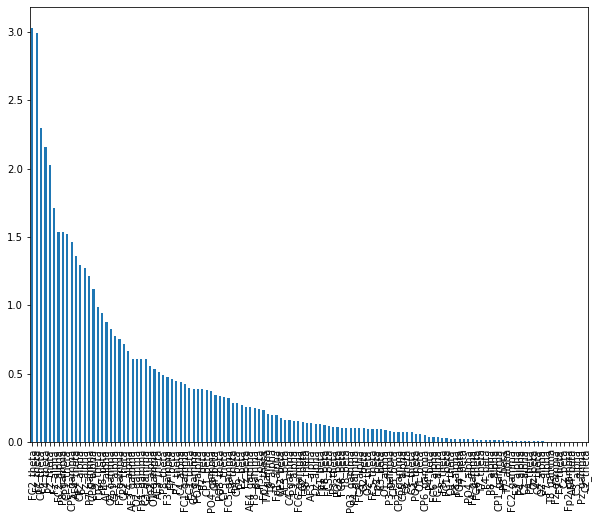

In [ ]:
fvalues = pd.Series(draft)
fvalues.index = data.columns
fvalues.sort_values(ascending=False)
#fvalues.to_csv('fscore_final.csv')
fvalues.sort_values(ascending = False).plot.bar(figsize=(10,8))

In [ ]:
shyam = fvalues.sort_values(ascending = False)
da = pd.DataFrame(shyam)
da.to_csv("channel_rank.csv")
cr = pd.read_csv("channel_rank.csv")
sort_channel_name = list(cr["Unnamed: 0"])

In [ ]:
print(sort_channel_name)
print(draft)

In [ ]:
print(sort_channel_name)
print(draft)

In [ ]:
for i in range(1, len(sort_channel_name)):
  print(svmclassifier(sort_channel_name[:i]))

In [ ]:
svmclassifier(['FC2', 'CP6', 'F7'])

NameError: ignored

In [ ]:
svmclassifier(['F7', 'CP6', 'CP1',])

0.625

In [ ]:
mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
# for theta band
data_theta = pd.read_csv(mypath + '_theta.csv')

In [ ]:
mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
# for theta band
data_theta = pd.read_csv(mypath + '_theta.csv')
X = np.array(data_theta[['Fz_theta', 'FC2_theta', 'CP6_theta', 'F7_theta', 'FC1_theta']])
y = em_labels
myscore_1 = fisher_score(X, y)
mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
# for theta band
data_alpha = pd.read_csv(mypath + '_alpha.csv')
X = np.array(data_alpha[['Fz_alpha', 'FC2_alpha', 'CP6_alpha', 'F7_alpha', 'FC1_alpha']])
y = em_labels
myscore_2 = fisher_score(X, y)
mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
# for theta band
data_beta = pd.read_csv(mypath + '_beta.csv')
X = np.array(data_beta[['Fz_beta', 'FC2_beta', 'CP6_beta', 'F7_beta', 'FC1_beta']])
y = em_labels
myscore_3 = fisher_score(X, y)
mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject_name + "/" + subject_name
# for theta band
data_gamma = pd.read_csv(mypath + '_gamma.csv')
X = np.array(data_gamma[['Fz_gamma', 'FC2_gamma', 'CP6_gamma', 'F7_gamma', 'FC1_gamma']])
y = em_labels
myscore_4 = fisher_score(X, y)
#print(X, y)

In [ ]:
myscore = myscore_1 + myscore_2 + myscore_3 + myscore_4

In [ ]:
myscore_1

In [ ]:
myscore_2

In [ ]:
myscore_3

In [ ]:
myscore

In [ ]:
np.min(myscore)

In [ ]:
np.max(myscore)

0.141670372612533

In [ ]:
svmclassifier(['CP1', 'P3', 'Fz', 'P8'])

0.575

In [ ]:
svmclassifier(['FC2', 'CP6', 'F7'])

0.775

# Main Drive Code

In [ ]:
subject_names = ["s01", "s02", "s03", "s04", "s05", "s06", "s07", "s08", "s09", "s10", "s11", "s12", "s13", "s14", "s15", "s16", "s17", "s18", "s19", "s20", "s21",
                "s22", "s23", "s24", "s25", "s26", "s27", "s28", "s29", "s30", "s31", "s32"]
class_labels = ["arousal", "valence", "all"]

In [ ]:
for subject_name in subject_names:
  print("-"*150)
  print("Subject Name: ", subject_name)
  print("-"*150)
  for class_label in class_labels:
    print("Class Label: ", class_label)
    link = "/content/drive/MyDrive/Deap/" + subject_name + ".dat"
    with open(link, 'rb') as f:
      raw_data = pickle.load(f, encoding = 'latin1')
    labels = raw_data['labels']
    em_labels = emotion_label(labels, class_label) # get the emotion labels
    channel_name = get_fisher_score(subject_name, em_labels)
    optimal_channel_name = growing_phase(channel_name)
    sort_channel_name = pruning_phase_get_fscore(optimal_channel_name, subject_name, em_labels)
    final_channel_name = pruning_phase(sort_channel_name)
  print("-"*150)

------------------------------------------------------------------------------------------------------------------------------------------------------
Subject Name:  s01
------------------------------------------------------------------------------------------------------------------------------------------------------
Class Label:  arousal
Accuracy in Growing Phase:  0.75
No of selected channels in Growing Phase:  7
Channels selected in Growing Phase:  ['P7', 'CP1', 'P3', 'P8', 'Fz', 'CP5', 'Cz']
Accuracy in Pruning Phase:  0.75
No of selected channels in Pruning Phase:  7
Channels selected in Pruning Phase:  ['P7', 'CP1', 'P3', 'P8', 'Fz', 'CP5', 'Cz']
Class Label:  valence
Accuracy in Growing Phase:  0.725
No of selected channels in Growing Phase:  6
Channels selected in Growing Phase:  ['Fz', 'FC2', 'CP6', 'F7', 'Fp1', 'FC6']
Accuracy in Pruning Phase:  0.725
No of selected channels in Pruning Phase:  6
Channels selected in Pruning Phase:  ['Fz', 'FC2', 'CP6', 'F7', 'Fp1', 'FC6']
C

KeyboardInterrupt: ignored